<a href="https://colab.research.google.com/github/Anu00parajuli/Swastha-Aalu/blob/anushka/Notebook/FinalYearProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d muhammadardiputra/potato-leaf-disease-dataset

 36% 9.00M/25.2M [00:00<00:00, 66.7MB/s]
100% 25.2M/25.2M [00:00<00:00, 133MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/potato-leaf-disease-dataset.zip','r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from PIL import Image

from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
TRAINING_DIR = os.path.join('/content/Potato/Train')
VALIDATION_DIR = os.path.join('/content/Potato/Valid')
TESTING_DIR = os.path.join('/content/Potato/Test')
#os.path.join("content",'otherdirectory","train")

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 900 files belonging to 3 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 300 files belonging to 3 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TESTING_DIR,
                                                           shuffle=False,
                                                           labels='inferred',
                                                           label_mode='categorical',
                                                           image_size=IMG_SIZE)

Found 300 files belonging to 3 classes.


In [ ]:
class_names = train_dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

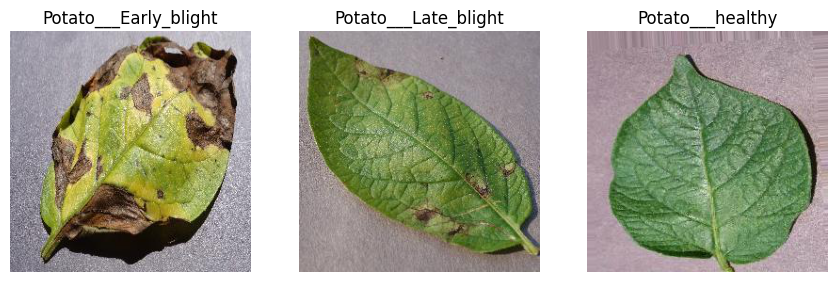

In [ ]:
classes = os.listdir('Potato/Train')

plt.figure(figsize=(18,8))

for i, class_ in enumerate(classes):
    pic = os.listdir('Potato/Train/'+ class_)[0]
    image = Image.open('Potato/Train/'+class_+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2, 5, i+1)
    plt.title(class_)
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [ ]:
categories = []
train = []
val= []
test = []

folders = os.listdir('Potato/Train')
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join('Potato/Train', f))))

folders = os.listdir('Potato/Valid')
for f in folders:
    val.append(len(os.listdir(os.path.join('Potato/Valid', f))))

folders = os.listdir('Potato/Test')
for f in folders:
    test.append(len(os.listdir(os.path.join('Potato/Test', f))))

data_count = pd.DataFrame({'categories': categories,
                     'train': train,
                     'val': val,
                     'test': test
                    })

data_count

,categories,train,val,test
0,Potato___Early_blight,300,100,100
1,Potato___Late_blight,300,100,100
2,Potato___healthy,300,100,100


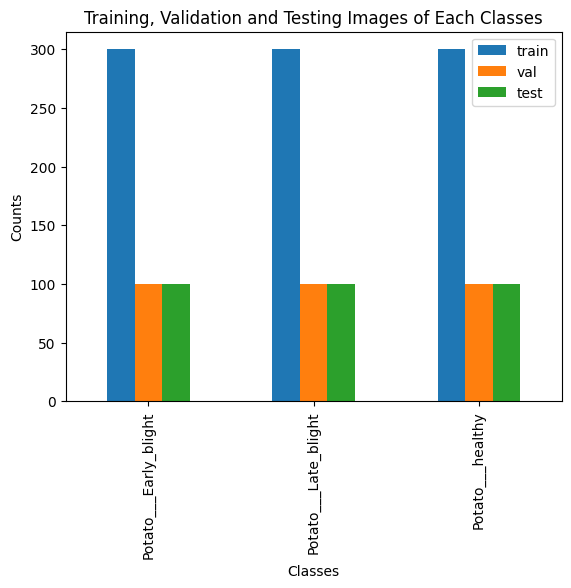

In [ ]:
data_count.plot.bar(x='categories', title="Training, Validation and Testing Images of Each Classes")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

In [ ]:
# Configure the dataset for performance
# Use buffered prefetching to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmentation(x):
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(factor=0.2),
    ])(x)

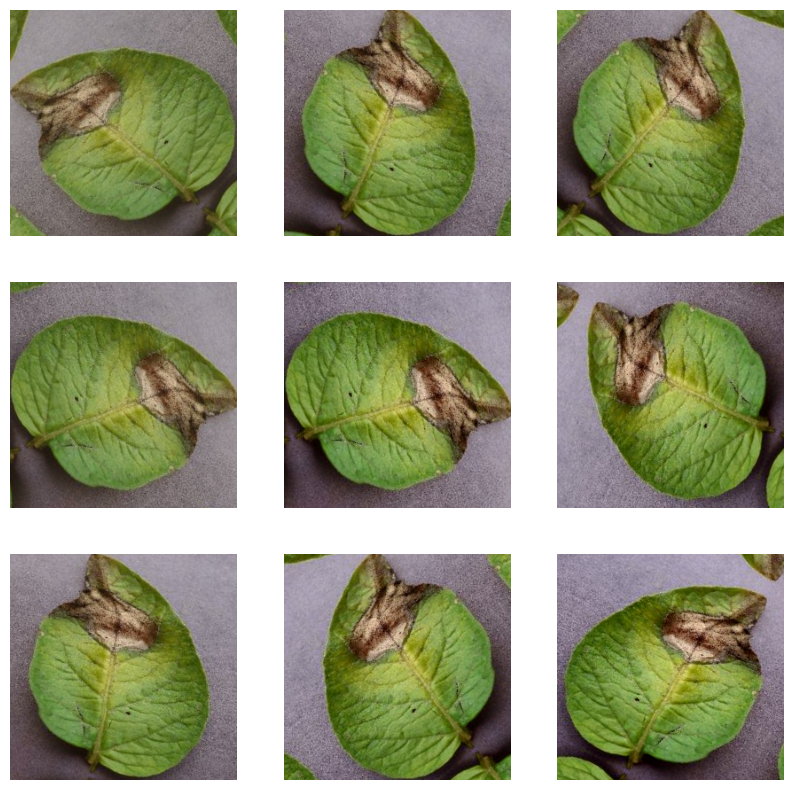

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
def preprocess_input(x):
    return tf.keras.layers.Rescaling(1./255, offset=-1)(x)


def feature_extractor(x):
    x = tf.keras.layers.Conv2D(input_shape=(IMG_SIZE), filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(input_shape=(IMG_SIZE), filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    return x

def classifier(x):
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x


def prediction_layer(x):
    return tf.keras.layers.Dense(10, activation='softmax')(x)

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = feature_extractor(x)
x = classifier(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
learning_rate = 0.00001

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                             

In [ ]:
os.path.join('/content/Potato/')
log_csv = CSVLogger('./custom_NN_logs1.csv', separator=',', append=False)
checkpoint = ModelCheckpoint('./custom_NN.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop, log_csv]

In [ ]:
epochs = 30

In [ ]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.7767 
Epoch 1: val_loss improved from inf to 2.31070, saving model to ./custom_NN.hdf5
29/29 [==============================] - 529s 18s/step - loss: 0.5761 - accuracy: 0.7767 - val_loss: 2.3107 - val_accuracy: 0.0000e+00
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8644 
Epoch 2: val_loss did not improve from 2.31070
29/29 [==============================] - 519s 18s/step - loss: 0.3853 - accuracy: 0.8644 - val_loss: 2.3494 - val_accuracy: 0.0000e+00
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.8933 
Epoch 3: val_loss improved from 2.31070 to 2.27393, saving model to ./custom_NN.hdf5
29/29 [==============================] - 517s 18s/step - loss: 0.3002 - accuracy: 0.8933 - val_loss: 2.2739 - val_accuracy: 0.3333
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.9211 
Epoch 